### Initalize the model

In [19]:
# from langchain_groq import ChatGroq
# llm = ChatGroq(
#     model_name="deepseek-r1-distill-llama-70b",
#     temperature=0
# )

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
response=llm.invoke("what is length of wall of china?")
response

AIMessage(content='The Great Wall of China is approximately 13,171 miles (21,196 kilometers) long. This length includes all of its branches and sections, many of which are not continuous but rather consist of various walls built over different dynasties in Chinese history.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 15, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BkSwMxIERm0TVN3gFurZ097a2OdZz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--f8b1c6a2-cc57-4d0a-8716-cbf00b157237-0', usage_metadata={'input_tokens': 15, 'output_tokens': 52, 'total_tokens': 67, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'outpu

### Custom tool

In [20]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

### Inbuilt tools

In [21]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()
search.invoke("what is the latest update on iphone17 release?")

"Apple announced the latest iPhone software, iOS 26, on Monday, June 9. The first release for developers came later the same day. Just three days later, Apple released a second build of the first ... This beta release will be available to anyone who wants it via enrollment at beta.apple.com. Like all beta software, iOS 26's public beta is expected to include bugs and performance issues that ... The beta release lets a developer or company test its software program or system to emulate real-world use before a general release. Also: Your CarPlay is getting a major overhaul on iOS 26: 3 new ... Apple revealed its plans for its next iOS update at the WWDC keynote on June 9, 2025. The company also showed off new features for the next iPadOS update, macOS Tahoe, watchOS and more at the ... CUPERTINO, CALIFORNIA Apple today previewed iOS 26, a major update that brings a beautiful new design, intelligent experiences, and improvements to the apps users rely on every day. The new design provides

In [22]:
import yfinance as yf

@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

### Binding the tools with LLM

In [23]:
tools=[multiply, add, divide, search, get_stock_price]
llm_with_tools=llm.bind_tools(tools=tools)

response=llm_with_tools.invoke("what is 2+2?")
print("content_string: "+ response.content)
print(response.tool_calls)

response=llm_with_tools.invoke("what is 10/2?")
print("content_string: "+ response.content)
print(response.tool_calls)

response=llm_with_tools.invoke("what is a current age of the TATA Group?")
print("content_string: "+ response.content)
print(response.tool_calls)

response=llm_with_tools.invoke("what is a stock price of AAPL?")
print("content_string: "+ response.content)
print(response.tool_calls)


content_string: 2 + 2 equals 4.
[]
content_string: 
[{'name': 'divide', 'args': {'a': 10, 'b': 2}, 'id': 'call_4THzhHMzvOsGwdOEUcTsO27Z', 'type': 'tool_call'}]
content_string: The Tata Group was founded in 1868. To find its current age as of 2023, we simply subtract the founding year from the current year:

2023 - 1868 = 155

The Tata Group is currently 155 years old.
[]
content_string: 
[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id': 'call_GABFdmeWpyjIup2Ff40RjyUf', 'type': 'tool_call'}]


In [24]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."
user_query=["tell me what is 2+2"]

### Building the graph

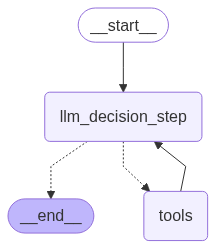

In [25]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

def function_1(state:MessagesState):
    user_question=state["messages"]
    input_question = [SYSTEM_PROMPT]+user_question
    response = llm_with_tools.invoke(input_question)
    return {
        "messages":[response]
    }


builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_decision_step")
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
builder.add_edge("tools","llm_decision_step")
react_graph=builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [26]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='3dcea523-28ee-40e9-ab8b-3faaaae49f8a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qPB987g7YbuzZWshoJenhWZ2', 'function': {'arguments': '{"query":"Narendra Modi age 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 335, 'total_tokens': 358, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BkSwroHuM3lQnH48gEb4nqVUC1gV9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--85fbb30a-061f-4567-a703-badd53dfca1d-0', tool_calls=[{'name': 'duckduckgo_search', 'ar

In [27]:
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]
react_graph.invoke({"messages":message})

{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='c8e74b89-1626-4e43-909e-b4ae2fd0d7ba'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EKfysAUStkIFFZcT1oN3U0W4', 'function': {'arguments': '{"query":"Elon Musk net worth"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 339, 'total_tokens': 360, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BkSwvyKVNuhNBZbpjCPDdHlCmovFx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4020207-bfc1-4195-ac6d-1df4448c7e24-0', tool_calls=[{'name': 'duckd

In [28]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]
response=react_graph.invoke({"messages":message})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_YwwKulbm3EERivgLQEgBPvmI)
 Call ID: call_YwwKulbm3EERivgLQEgBPvmI
  Args:
    query: speed of light in m/s
  multiply (call_dIlaR5fifo2MLsHSh9Me9GYA)
 Call ID: call_dIlaR5fifo2MLsHSh9Me9GYA
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: duckduckgo_search

The speed of light in vacuum, commonly denoted c, is a universal physical constant exactly equal to 299,792,458 metres per second (approximately 300,000 kilometres per second; 186,000 miles per second; 671 million miles per hour). It is exact because, by international agreement, a metre is defined as the length of the path travelled by light in vacuum during a time interval of 1⁄299 792 458 ... Learn what is

In [29]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_ZzPqNDMvrcBNJNmxoC3DycWZ)
 Call ID: call_ZzPqNDMvrcBNJNmxoC3DycWZ
  Args:
    ticker: AAPL
  duckduckgo_search (call_87MjuShLkx6Bia7HuML5W3lG)
 Call ID: call_87MjuShLkx6Bia7HuML5W3lG
  Args:
    query: current stock price of Apple
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $195.64.
================================= Tool Message =================================
Name: duckduckgo_search

Historical Stock Price Lookup. Investor Relations > Stock Price . Apple Footer See today's Apple stock price (NASDAQ: AAPL), related news, stock ratings, valuation, dividends and more to help you make your investing decisions. A high-level overview of Apple Inc. (AAPL) 

In [30]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_jM850S7rzj9FONhWsoLkPs2y)
 Call ID: call_jM850S7rzj9FONhWsoLkPs2y
  Args:
    ticker: AAPL
  duckduckgo_search (call_fYMACTF4WhMXnRwdnruYHotv)
 Call ID: call_fYMACTF4WhMXnRwdnruYHotv
  Args:
    query: Apple latest news
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $195.64.
================================= Tool Message =================================
Name: duckduckgo_search

Apple News & Mac Rumors Breaking All DayAfter years (and years, and years) of waiting and speculation, Spotify 's long-promised lossless audio feature appears to be inching closer to reality ... At today's WWDC 2025 keynote event, Apple